Deep Learning Morpion Solitaire
===============================

Part 1: The game
================


When I was younger, I used to play a pen-and-paper game called [*Morpion solitaire*](https://en.wikipedia.org/wiki/Join_Five) (or sometimes *Join Five*, or simply the *Line game*). 
The goal of the game is to draw as many lines and dots on a piece of paper following some simple rules.
To begin with, take a piece of graph paper and draw 36 dots in the following pattern:

In [53]:
#hide
import sys
sys.path.append("../")
from MorpionSolitaire import *
from PIL import Image

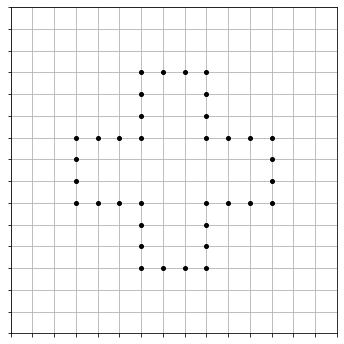

In [32]:
#hide
grid = Grid('cross')
grid.print(view = 16)

text

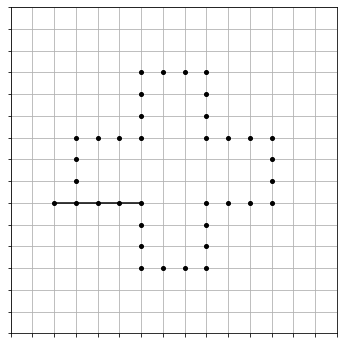

In [33]:
#hide
grid.add_segment((10, 14, 1, 0))
grid.print(view = 16)

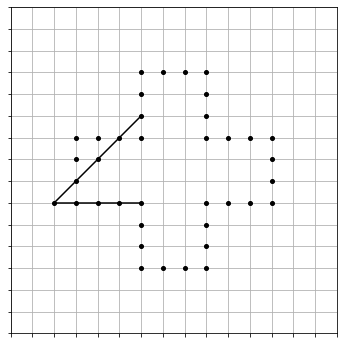

In [34]:
#hide
grid.add_segment((12, 16, 3, 2))
grid.print(view = 16)

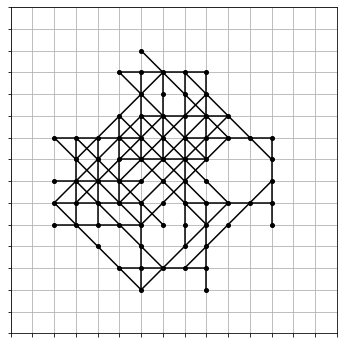

In [50]:
#hide
game = NewGame().play(index = 0, depth = 40)
game.grid.print(view = 16)

Let the computer play
-------------------------------


I wrote a python code to let (see *Part 2: Implementation*, to appear)


playing 100,000 games at random:

best score obtained is 87, quite far from the world record!

grid is:

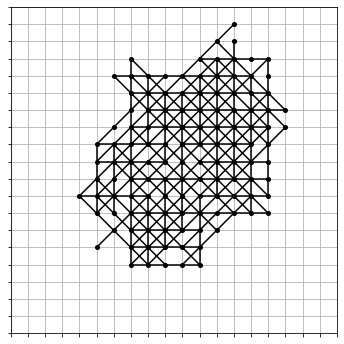

In [57]:
#hide
Image.open('../random_exploration_data/best_grid.png')

here is the distribution of scores

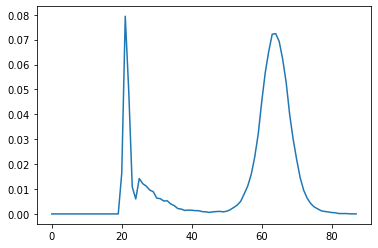

In [58]:
#hide
Image.open('../random_exploration_data/distribution.png')

This shows that despite simple rules, the dynamics of the game is very interesting: many random explorations end with a miserable score of about 20-25 points, but when the 40-points barrier is passed, they are again many more possible outputs, with a peak around 65 points. One also sees that it is in fact very hard to reach high scores from a purely random exploration.

Why humans know better
------------------------------------



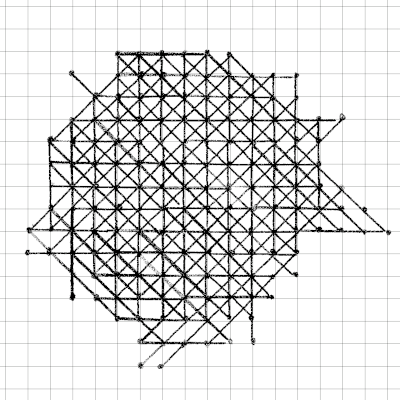

In [60]:
#hide
Image.open('../drawings/result_124.png')

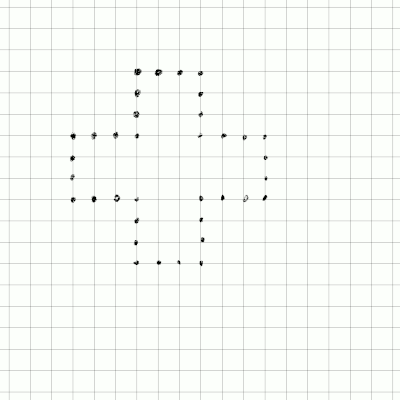

In [63]:
#hide
Image.open('../drawings/animation_124.gif')

Deep learning
-------------
